# 1st module

Load the dataset mat file.

In [132]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sb

dataset_fname = "datasets/dataset_static.mat"

mat_contents = sio.loadmat(dataset_fname)
mat_contents.keys()

dict_keys(['__header__', '__version__', '__globals__', 'parsedData'])

The data is on the mat file variable. In this case: `parsedData`.

In [133]:
mat_var = "parsedData"

mdata = mat_contents[mat_var]
data = dict()
for col in mdata.dtype.names:
    mdata_col = mdata[col][0]
    # probe first col element to find if it's a dumb single item array (loving it)
    is_single_elem = len(mdata_col[0][0]) == 1
    data[col] = [d[0][0] if is_single_elem else d[0] for d in mdata_col]
data.keys()

dict_keys(['time', 'angle', 'step_dist', 'intensities'])

We'll build a dataframe because they're cool.

In [135]:
df = pd.DataFrame(data)
df.head()

,time,angle,step_dist,intensities
0,10.280058,180.000000,0.012531,"[0, 0, 0, 0, 43, 68, 90, 106, 111, 108, 100, 9..."
1,10.321921,181.800003,0.012531,"[0, 0, 0, 17, 51, 73, 87, 106, 116, 117, 92, 9..."
2,10.364880,183.600006,0.012531,"[0, 0, 0, 11, 43, 63, 84, 106, 119, 119, 103, ..."
3,10.408035,185.399994,0.012531,"[0, 0, 0, 0, 55, 76, 94, 108, 113, 113, 100, 1..."
4,10.451024,187.199997,0.012531,"[0, 0, 0, 15, 44, 63, 78, 102, 113, 113, 109, ..."


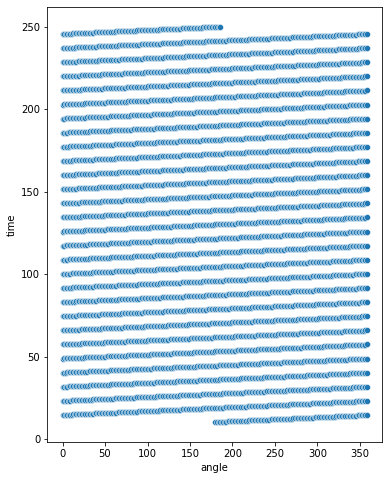

In [141]:
plt.figure(figsize=(6.0, 8.0))
sb.scatterplot(data=df, x="angle", y="time");